## Training a convolutional neural network

#### Imports

In [47]:
import os
import numpy as np
import pandas as pd
import random
import datetime

import tensorflow as tf
import keras
from tensorflow import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/k10/mr1465/Honours2022/scripts/neural_nets/cnn')
import workshop_plots

In [2]:
results_directory = '/g/data/k10/mr1465/Honours2022/scripts/neural_nets/cnn' # os.getcwd()
data_directory = '/g/data/k10/mr1465/Honours2022/scripts/neural_nets/cnn/workshop_data.csv'

In [3]:
# Global variables
RANDOM_STATE = 42

#### Load data

In [4]:
df = pd.read_csv(data_directory)

In [5]:
df.columns # View variables

Index(['Himawari Latitude', 'Himawari Longitude', 'Himawari Surface Type',
       'Himawari Observation Azimuth Angle',
       'Himawari Observation Elevation Angle', 'Himawari Solar Azimuth Angle',
       'Himawari Solar Zenith Angle', 'Himawari Band 1 Mean at 2km Resolution',
       'Himawari Band 1 Sigma at 2km Resolution',
       'Himawari Band 2 Mean at 2km Resolution',
       'Himawari Band 2 Sigma at 2km Resolution',
       'Himawari Band 3 Mean at 2km Resolution',
       'Himawari Band 3 Sigma at 2km Resolution',
       'Himawari Band 4 Mean at 2km Resolution',
       'Himawari Band 4 Sigma at 2km Resolution',
       'Himawari Band 5 Value at 2km Resolution',
       'Himawari Band 6 Value at 2km Resolution',
       'Himawari Band 7 Value at 2km Resolution',
       'Himawari Band 8 Value at 2km Resolution',
       'Himawari Band 9 Value at 2km Resolution',
       'Himawari Band 10 Value at 2km Resolution',
       'Himawari Band 11 Value at 2km Resolution',
       'Himawari Band 

##### Check data coverage of target classes

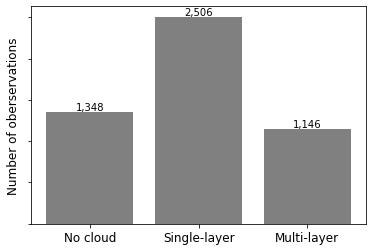

In [39]:
df_ml_mask = df['CPR-CALIOP Multi_Layer_Mask']
workshop_plots.histogram_label_frequency(df_ml_mask, results_dir=results_directory)

#### Prepare data

##### Split data into training and testing sets

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
df_train, df_test = df_train.dropna(), df_test.dropna()

##### Select predictors and target

In [18]:
# Classify variables for ease of sub-selection

ahi_metadata = ['Himawari Folder Name', 'Himawari Original Array Position', 'Himawari Scene Start Time', 'Himawari Scene End Time',
                'Himawari Scene Start Time t-1', 'Himawari Scene End Time t-1']

# All possible features start with "Himawari"
ahi_features = [col for col in df.columns if col.startswith('Himawari') if col not in ahi_metadata]

# Spectral observation channels
ahi_channels = [x for x in ahi_features if x.startswith('Himawari Band')] 
ahi_channels = ahi_channels + [x + ' t-1' for x in ahi_channels]
sigma_channels = [x for x in ahi_channels if 'Sigma' in x] # Standard deviation of the downscaled channels
day_channels = [x for x in ahi_channels if int(x[14:16]) < 7] # Channels that operate during the daylight hours only

In [19]:
# List features and target to use
features = [x for x in ahi_features if x not in sigma_channels] # Dropping the standard deviation channels
target = ['CPR-CALIOP Multi_Layer_Flag']

# How many classes are being targetted?
n_classes = 2

In [20]:
# Define features dataframe: X
raw_X_train = df_train.loc[:,features]
raw_X_test = df_test.loc[:,features]

In [21]:
# Define target dataframe: y
raw_y_train = df_train.loc[:, target]
raw_y_test = df_test.loc[:, target]

##### Transform data for convolution

In [22]:
# Normalise
scaler = StandardScaler().fit(raw_X_train)
raw_X_train = pd.DataFrame(scaler.transform(raw_X_train), columns=features)
raw_X_test = pd.DataFrame(scaler.transform(raw_X_test), columns=features)

In [23]:
# Shape data for convolution
g1 = [x for x in raw_X_test.columns if not x.startswith('Himawari Band')] # Static features
g2 = [x for x in raw_X_test.columns if x.endswith('Resolution')] # Time current
g3 = [x for x in raw_X_test.columns if x.endswith('t-1')] # Time previous
arrays = []
for i in range(len(raw_X_test)):
    arrays.append(np.array([raw_X_test.iloc[i][g1+g3].values, raw_X_test.iloc[i][g1+g2].values]))
X_test = np.stack(arrays)
arrays = []
for i in range(len(raw_X_train)):
    arrays.append(np.array([raw_X_train.iloc[i][g1+g3].values, raw_X_train.iloc[i][g1+g2].values]))
X_train = np.stack(arrays)

In [50]:
# Encode target classes (reshape)
encoder = OneHotEncoder()
y_train = encoder.fit(raw_y_train.values.reshape(-1,1))
y_train = y_train.transform(raw_y_train.values.reshape(-1,1)).toarray()
y_test = encoder.fit(raw_y_test.values.reshape(-1,1))
y_test = y_test.transform(raw_y_test.values.reshape(-1,1)).toarray()

In [25]:
# View results
print(X_train.shape)
print(y_train.shape)

(2805, 2, 23)
(2805, 2)


### Create model

In [26]:
# Define model architechture
def define_model(hp, n_features, n_classes, n_timesteps=2, model_optimiser='adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=hp['n_filters'], kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features))) # Convolve
    model.add(keras.layers.MaxPooling1D(pool_size=2, padding='same')) # Pooling layer
    model.add(keras.layers.Dropout(0.2)) # Dropout
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_features, activation='relu')) # Fully connected layer
    # Inner/hidden layers
    for i in range(hp['n_layers']):
        model.add(keras.layers.Dense(hp['n_neurons'], activation='relu'))
    model.add(keras.layers.Dense(n_classes, activation='softmax')) # Number of output neurons, depends on number of classes wanted for classification
    model.compile(loss='categorical_crossentropy', optimizer=model_optimiser, metrics=['accuracy'])
    return model

In [27]:
def evaluate_model(model, X_test, y_test):
    """
    evaluate model on test set and show results in dataframe.

    Parameters
    ----------
    model : keras model
        trained keras model.
    X_test : numpy array
        Features of holdout set.
    y_test : numpy array
        Labels of holdout set.

    Returns
    -------
    display_df : DataFrame
        Pandas dataframe containing evaluation results.
    """
    # Get accuracy metrics
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)
    # Get PoD of multilayer
    predictions = model.predict(X_test)
    y_pred_ml = np.ravel(encoder.inverse_transform(predictions)) == 2
    y_test_ml = np.ravel(encoder.inverse_transform(y_test)) == 2 # Number correct
    # Output
    eval_dict['PoD'] = np.mean([y_test_ml[i] == y_pred_ml[i] for i in range(len(y_test_ml)) if y_test_ml[i] == 1]) # Probility of detection
    display_df = pd.DataFrame(eval_dict, index=[0])
    return display_df

##### Chose model hyper parameters

In [28]:
# Choose optimiser

# optimiser = 'Adam'
optimiser = 'SGD'

In [29]:
# Choose model architecture specifications
hp = {'n_layers': 5,
        'n_neurons': 100,
        'n_epochs': 150,
        'n_filters': 64,
        'optimiser': optimiser,
        }

##### Perform K-fold Cross Validation

In [75]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform CV
fold_results = []
for train, test in kfold.split(X_train, y_train[:,0]):
    model = define_model(hp, n_features=X_train.shape[2], n_classes=n_classes, model_optimiser=hp['optimiser'])
    model.fit(X_train[train], y_train[train, :], epochs=hp['n_epochs'], batch_size=10, verbose=0)
    fold_results.append(evaluate_model(model, X_train[test], y_train[test, :]))

7/7 [==============================] - 0s 1ms/step


/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7/7 [==============================] - 0s 1ms/step


/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7/7 [==============================] - 0s 2ms/step


/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7/7 [==============================] - 0s 2ms/step


/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7/7 [==============================] - 0s 2ms/step


/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##### CV results

In [86]:
cv_results = pd.concat(fold_results)
cv_results

,loss,accuracy,PoD
0,0.354904,0.831776,NaN
0,0.360377,0.835681,NaN
0,0.284772,0.849765,NaN
0,0.440189,0.868545,NaN
0,0.358502,0.835681,NaN


In [88]:
# Get mean CV statistics
cv_results.mean(axis=0)

loss        0.359749
accuracy    0.844289
PoD              NaN
dtype: float64

#### Train final model configuration on all train set data

In [35]:
# Fit final model
model_best = define_model(hp, n_features=X_train.shape[2], n_classes=n_classes, model_optimiser=hp['optimiser'])
model_best.fit(X_train, y_train, epochs=hp['n_epochs'], batch_size=10, verbose=0)

In [32]:
# Training set results
evaluate_model(model_best, X_train, y_train)

88/88 [==============================] - 0s 1ms/step


/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,loss,accuracy,PoD
0,0.189593,0.918004,NaN


## Assess results on test set

In [33]:
# Get basic statistics
evaluate_model(model_best, X_test, y_test)

21/21 [==============================] - 0s 1ms/step


/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/mlenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,loss,accuracy,PoD
0,0.275746,0.879104,NaN


In [51]:
# Predict on test set
y_pred = model_best.predict(X_test)
y_pred_cm = encoder.inverse_transform(y_pred)
y_test_cm = encoder.inverse_transform(y_test)

21/21 [==============================] - 0s 2ms/step


##### 1. Confusion matrix

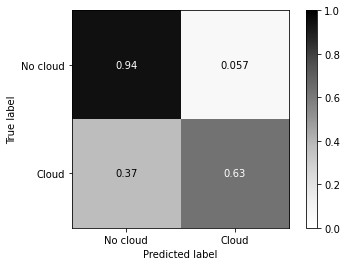

In [69]:
# Format options
# display_labels = ["No cloud", "Single-layer", "Multi-layer"]
display_labels = ["No cloud", "Cloud"]
cmap = plt.cm.Greys
font_s = 12

# Calculate data
cnf_matrix = confusion_matrix(y_test_cm, y_pred_cm, normalize='true')

# Plot result
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap=cmap, ax=ax)
disp.ax_.get_images()[0].set_clim(0, 1) # Set cbar limits

fig.savefig('{}/confusion_matrix.jpg'.format(results_directory), dpi=300, bbox_inches='tight')

##### 2. ROC curve

In [59]:
# - Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
auc_di = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc_di[i] = auc(fpr[i], tpr[i])
# - Compute micro-average ROC curve and ROC area
fpr["all"], tpr["all"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
auc_di["all"] = auc(fpr["all"], tpr["all"])

In [63]:
# Format options for plot
meta_di = {0:['no cloud','darkred','--'], 1:['cloud','darkred',':'], 2:['multi-layer cloud','darkred','-.'], 'all':['all-classes','darkgreen','-']}

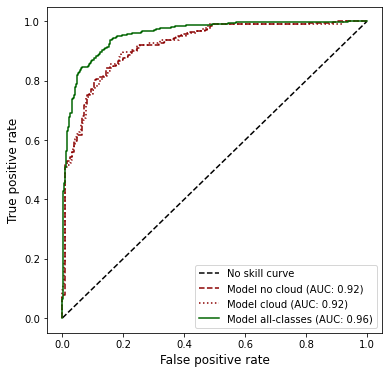

In [61]:
fig, ax = plt.subplots(figsize=(6,6))

# Plot no skill curve
ax.plot([0, 1], [0, 1], 'k--', label='No skill curve')

# Plot data
for key in auc_di.keys():
    ax.plot(fpr[key], tpr[key], label='Model {} (AUC: {:.2f})'.format(meta_di[key][0], auc_di[key]), c=meta_di[key][1], linestyle=meta_di[key][2]) # Plot results

# Format plot
ax.set_xlabel('False positive rate', fontsize=font_s)
ax.set_ylabel('True positive rate', fontsize=font_s)
ax.legend(loc='lower right', fontsize=font_s-2)

fig.savefig('{}/ROC.jpg'.format(results_directory), dpi=300, bbox_inches='tight')

##### 3. Precision and recall 

In [70]:
# True and flase postive rates for model threshold
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

In [72]:
# Get precision
# What proportion of positive identifications was actually correct?

In [73]:
precision = TP / (TP + FP)
print('Precsion =', precision)

Precsion = [0.71655987 0.91668444]


In [75]:
# Get recall (AKA Probability of detection)
# What proportion of actual positives was identified correctly?

In [76]:
recall = TP / (TP + FN)
print('Recall =', recall)

Recall = [0.94301471 0.62698413]
